In [1]:
import moscot
from moscot.problems.time import TemporalProblem

In [2]:
import scanpy as sc

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.generic import SinkhornProblem
import moscot.plotting as mpl
import pandas as pd
import os
import muon

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)
                         
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

['default', 'despine']


In [3]:
t0, t1 = 14.5, 15.5

In [4]:
tp0 = TemporalProblem.load("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/plots/OT_encodrine_analysis/TemporalProblem.pkl")

In [5]:
sc.pp.normalize_total(tp0.adata)
sc.pp.log1p(tp0.adata)

In [6]:
tp0.compute_entropy(t0, t1, batch_size=32)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


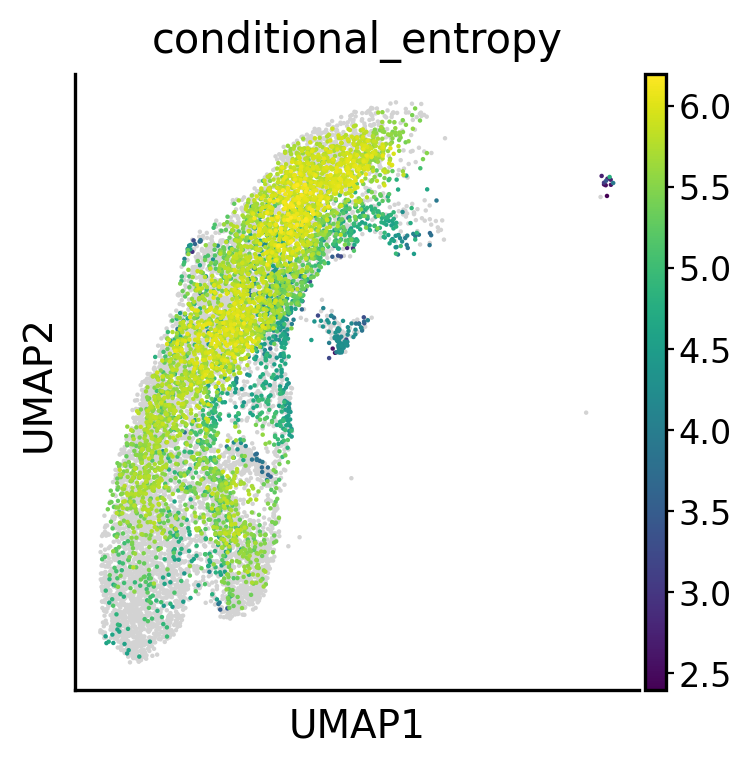

In [7]:
sc.pl.umap(tp0.adata, color=["conditional_entropy"])

In [8]:
import types
from typing import TYPE_CHECKING, Any, Dict, Literal, Mapping, Optional

import pandas as pd

from anndata import AnnData

from moscot import _constants
from moscot._types import ArrayLike, Str_Dict_t
from moscot.base.problems._mixins import AnalysisMixin, AnalysisMixinProtocol
from moscot.base.problems.compound_problem import B, K



def weighted_var(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    vars = []
    for i in range(len(weights)):
        w = weights[i] / np.sum(weights[i])
        
        # Calculate the weighted average
        average = np.average(values, weights=w, axis=0)
        
        # Calculate the weighted variance
        vars+=[np.average((values - average)**2, weights=w, axis=0)]
        
        
    return vars



def compute_cond_var(
    model,
    source: K,
    target: K,
    forward: bool = True,
    key_added: Optional[str] = "conditional_variance",
    batch_size: Optional[int] = None,
    attr: Dict[str, str] = {"attr": "obsm", "key": "X_pca"},
    **kwargs: Any,
) -> Optional[pd.DataFrame]:
    from statsmodels.stats.weightstats import DescrStatsW

    def _get_features(
            adata: AnnData,
            attr: Dict[str, Any] = {"attr": "obsm", "key": "X_pca"},
        ) -> ArrayLike:
            data = getattr(adata, attr["attr"])
            key = attr.get("key")
            if attr["attr"]=="X":
                return sc.get.obs_df(adata, keys=attr["key"], layer=None).values
            return data if key is None else data[key]

    filter_value = source if forward else target
    df = pd.DataFrame(
        index=model.adata[model.adata.obs[model._policy.key] == filter_value, :].obs_names,
        columns=[key_added] if key_added is not None else ["entropy"],
    )
    batch_size = batch_size if batch_size is not None else len(df)
    func = model.push if forward else model.pull
    tgt_features = _get_features(model[source, target].adata_tgt, attr)
    for batch in range(0, len(df), batch_size):
        cond_dists = func(
            source=source,
            target=target,
            data=None,
            subset=(batch, batch_size),
            normalize=True,
            return_all=False,
            scale_by_marginals=False,
            split_mass=True,
            key_added=None,
        )
        weighted_stats =weighted_var(tgt_features, cond_dists.T)
        df.iloc[range(batch, min(batch + batch_size, len(df))), 0] = np.mean(np.array(weighted_stats), axis=1)  # type: ignore[operator]
    if key_added is not None:
        model.adata.obs[key_added] = df
    return df if key_added is None else None

In [9]:
compute_cond_var(tp0, t0, t1, batch_size=32)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


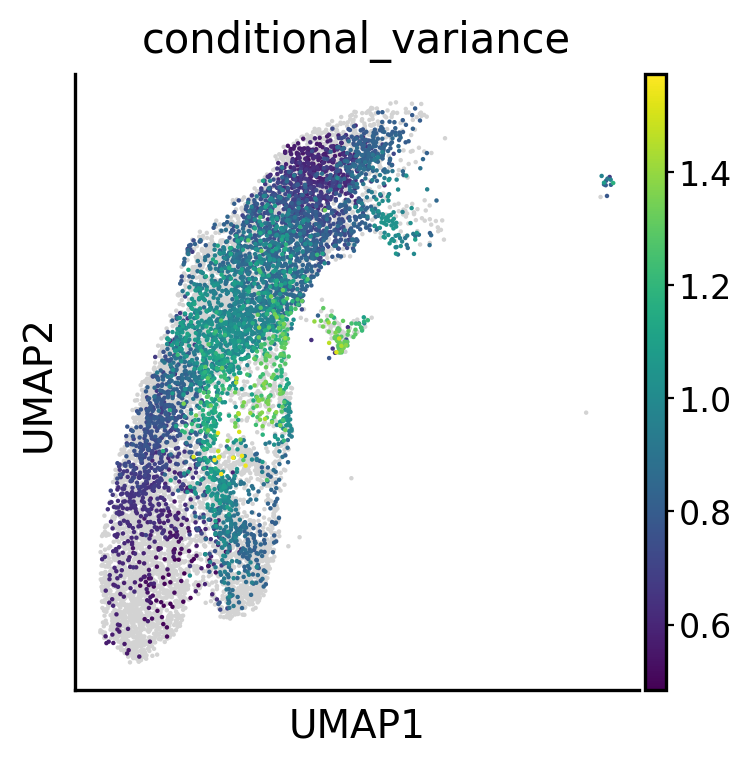

In [10]:
sc.pl.umap(tp0.adata, color=["conditional_variance"])

In [11]:
compute_cond_var(tp0, t0, t1, batch_size=32, attr={"attr": "X", "key": ["Neurog3"]})

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


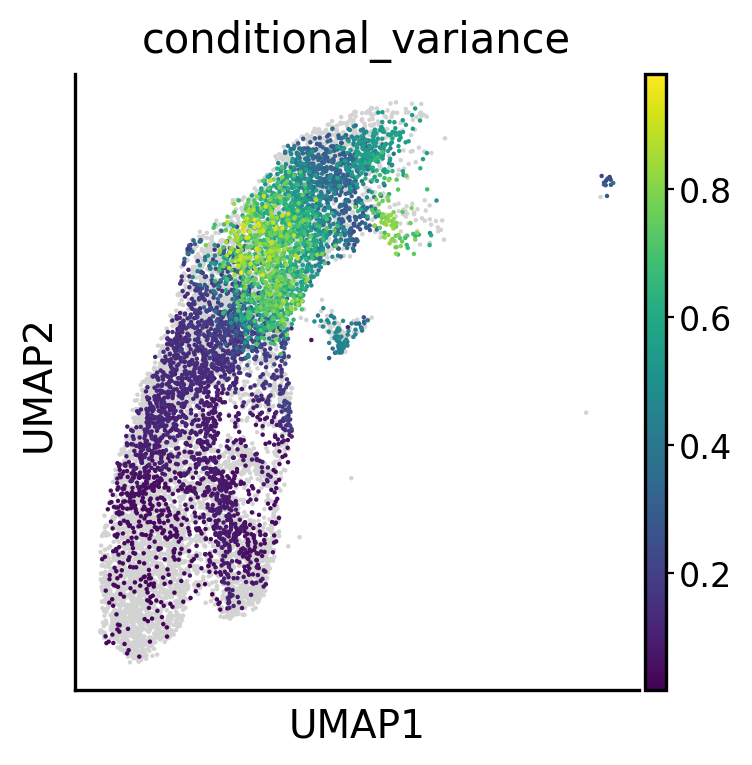

In [12]:
sc.pl.umap(tp0.adata, color=["conditional_variance"])

In [13]:
compute_cond_var(tp0, t0, t1, batch_size=32, attr={"attr": "X", "key": ["Ghrl"]})

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


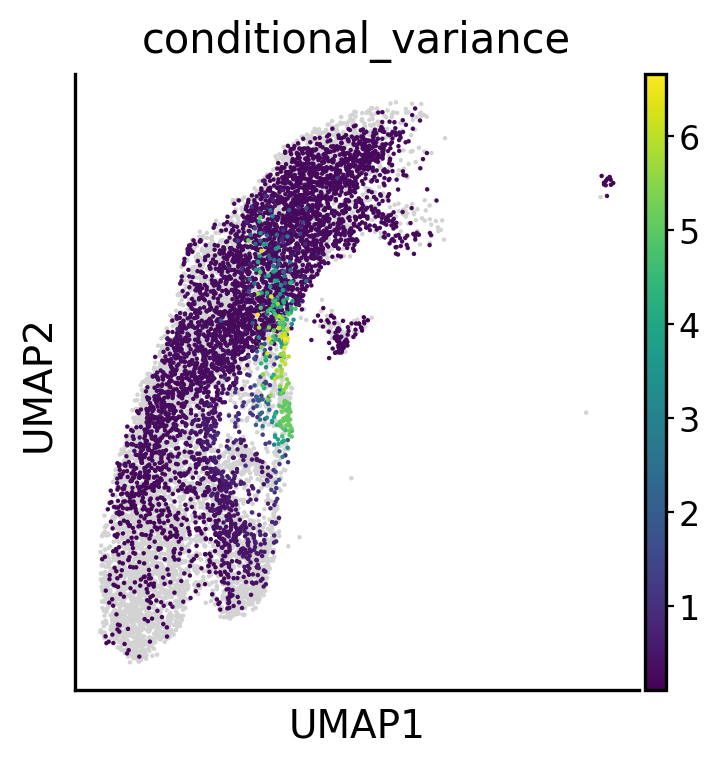

In [14]:
sc.pl.umap(tp0.adata, color=["conditional_variance"])

In [15]:
compute_cond_var(tp0, t0, t1, batch_size=32, attr={"attr": "X", "key": ["Ins2"]})

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


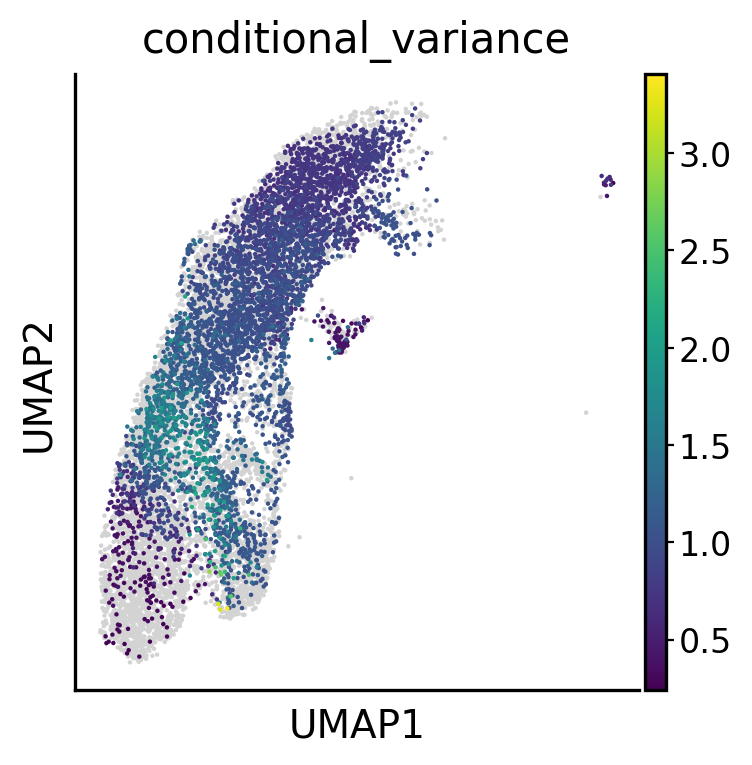

In [16]:
sc.pl.umap(tp0.adata, color=["conditional_variance"])

In [17]:
adata = tp0.adata[tp0.adata.obs["time"].isin((t0, t1))]

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='cell_type', ylabel='conditional_variance'>

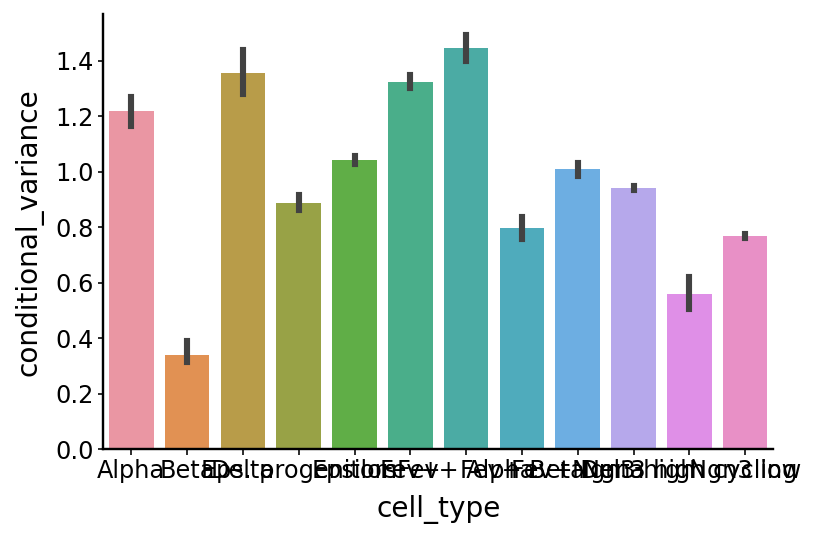

In [19]:
%matplotlib inline
sns.barplot(adata.obs, y="conditional_variance", x="cell_type")

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


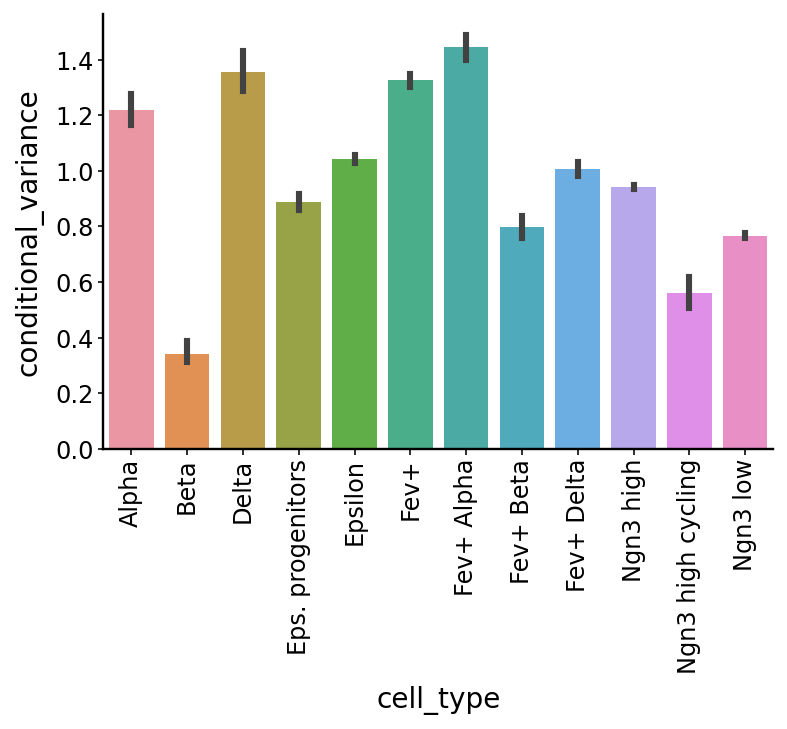

In [20]:
g = sns.barplot(adata.obs, y="conditional_variance", x="cell_type")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


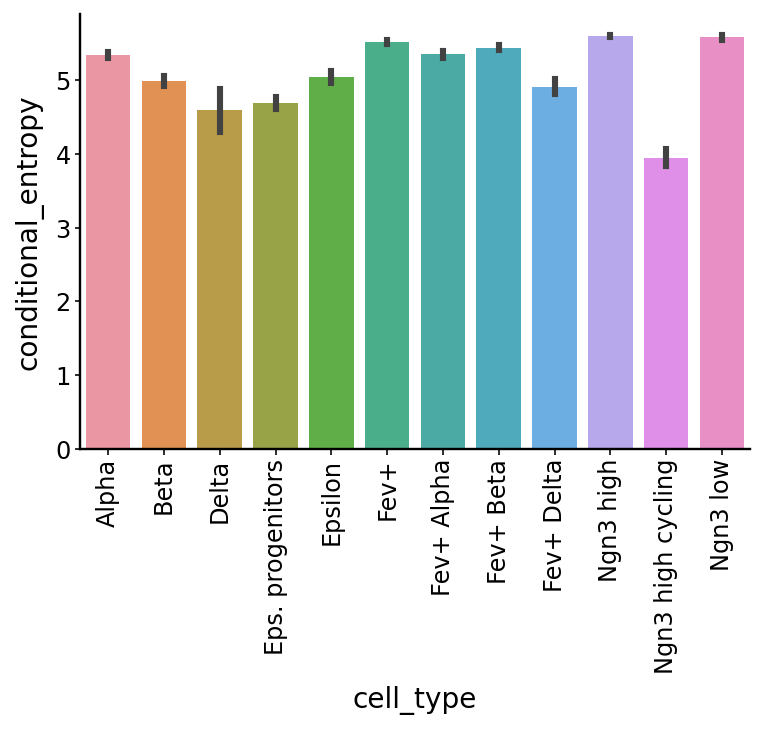

In [21]:
g = sns.barplot(adata.obs, y="conditional_entropy", x="cell_type")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [22]:
sc.pp.neighbors(adata, use_rep="X_pca")

In [23]:
df_dists = pd.DataFrame(index=adata.obs["cell_type"].unique(), columns=["mean_dist"])

In [24]:
from sklearn.metrics.pairwise import pairwise_distances

for ct in adata.obs["cell_type"].unique():
    data = adata[adata.obs["cell_type"]==ct].obsm["X_pca"]
    dist = pairwise_distances(data).mean()
    df_dists.loc[ct, "mean_dist"] = dist

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

In [25]:
df_dists

,mean_dist
Alpha,10.535953
Fev+,10.093472
Eps. progenitors,8.849004
Ngn3 high,11.203861
Ngn3 low,9.940623
Fev+ Beta,10.120769
Fev+ Alpha,9.969649
Ngn3 high cycling,11.622095
Fev+ Delta,11.355751
Epsilon,12.113378


In [26]:
adata.obs["dist_knn"] = adata.obsp["distances"].mean(axis=1)

In [27]:
df= adata.obs[["dist_knn", "cell_type"]].groupby("cell_type").mean().sort_values(by="dist_knn")

/tmp/ipykernel_3908565/3953337842.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df= adata.obs[["dist_knn", "cell_type"]].groupby("cell_type").mean().sort_values(by="dist_knn")


In [28]:
df["conditional_entropy"] = adata.obs[["conditional_entropy", "cell_type"]].groupby("cell_type").mean().sort_values(by="conditional_entropy")

/tmp/ipykernel_3908565/1132976959.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["conditional_entropy"] = adata.obs[["conditional_entropy", "cell_type"]].groupby("cell_type").mean().sort_values(by="conditional_entropy")


In [29]:
df["conditional_variance"] = adata.obs[["conditional_variance", "cell_type"]].groupby("cell_type").mean().sort_values(by="conditional_variance")

/tmp/ipykernel_3908565/2870501658.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["conditional_variance"] = adata.obs[["conditional_variance", "cell_type"]].groupby("cell_type").mean().sort_values(by="conditional_variance")


In [30]:
df

,dist_knn,conditional_entropy,conditional_variance
cell_type,,,
Ngn3 low,0.007532,5.585359,0.766975
Ngn3 high,0.007788,5.60016,0.941636
Eps. progenitors,0.007986,4.688085,0.887635
Beta,0.008129,4.990887,0.340375
Fev+ Beta,0.008798,5.440908,0.797064
Fev+,0.008992,5.522676,1.324904
Fev+ Delta,0.009086,4.911909,1.008085
Alpha,0.009329,5.345271,1.217802
Fev+ Alpha,0.009461,5.352817,1.444023


In [31]:
from scipy.stats import spearmanr
spearman_corr = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate Spearman correlation for each pair of columns
for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
            spearman_corr.loc[col1, col2] = 1.0  # The correlation with itself is 1
        else:
            corr, _ = spearmanr(df[col1], df[col2])
            spearman_corr.loc[col1, col2] = corr

In [32]:
spearman_corr

,dist_knn,conditional_entropy,conditional_variance
dist_knn,1.0,-0.552448,0.447552
conditional_entropy,-0.552448,1.0,0.090909
conditional_variance,0.447552,0.090909,1.0
